<a href="https://colab.research.google.com/github/karthikpuranik11/Hope-Speech-Detection-/blob/main/Malayalam/mBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3.3.1

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [9]:
train=pd.read_csv('/content/malayalam_hope_train.csv', header=None, names=['tweets','label','nan'], sep="\t")
train['labels']=LabelEncoder().fit_transform(train['label'])
train=train.drop(columns=['label','nan'])
train.labels.value_counts()

1    6205
0    1668
2     691
Name: labels, dtype: int64

In [10]:
val=pd.read_csv('/content/malayalam_hope_dev.csv', header=None, names=['tweets','label','nan'], sep="\t")
val['labels']=LabelEncoder().fit_transform(val['label'])
val=val.drop(columns=['label','nan'])
val

,tweets,labels
0,ജനകീയ കോടതിയുടെ വളരെ മികച്ച എപിസോടുകളിൽ ഒന്ന്....,0
1,Opera Mini - യുടെ അത്രേം വരില്ല UC,1
2,മറ്റുള്ള hetero sexuals നെ പോലെ കഴിവും സംസ്ക്ക...,0
3,@Mr President നിനക്ക് ഓക്കെ അത നല്ലത്...,1
4,RSS തീവ്രവാദികൾ നേരത്തെ പദ്ധതി ഇട്ട പ്രകാരം ചൈ...,1
...,...,...
1065,വാട്സ്ആപ്പ് ന് പകരം telegram app ഇത് ഇന്ത്യ യു...,1
1066,അടിസ്ഥാനമായി പള്ളിപ്രമാണങ്ങൾ മാറ്റിയെഴുതേണ്ടി ...,1
1067,Vella samsarikumpo blu ne nok..chevi kelkaatha...,1
1068,നികേഷിന്റെ വോളിൽ അമമയുടെ കൂടെ രണ്ടു പേരും നിൽക...,1


In [11]:
def punc(df):
    df['tweets'] = df['tweets'].str.replace(r"[+/#@&*$%:]",'')
    print(df)
punc(train)
punc(val)

                                                 tweets  labels
0     arya s nair may be athile karthikayude charctr...       1
1     വാങ്ങിയത് എന്ത് കുന്തം ആയാലും കളയാൻ പറ്റില്ലല്...       1
2     മാറുമറയ്ക്കാൻ നടത്തിയ സമരം ഒരു previlege issue...       0
3     ഇഷാനെ കൂടുതല് കെട്ടിപിടിക്കേണ്ട ഞങ്ങൾക്കറിയാം ...       1
4     ഇന്ത്യ ഇസ്‌ലാമിക രാജ്യമല്ല.. ഇന്ത്യൻ ഭരണഘടന മാ...       0
...                                                 ...     ...
8559            Evan eatha eee pottan oru vivaravumilla       1
8560  Ithinu pakaramayi upayogikkan pattunna Indian ...       1
8561                               സാറിന് നല്ലത് വരട്ടെ       1
8562  ഇങ്ങനത്തെ നല്ല നല്ല അറിവുകൾ പറഞ്ഞു തരുന്ന ഈ ഡോ...       0
8563  Happy wedding Anniverserygod bless you. കരയെല്...       0

[8564 rows x 2 columns]
                                                 tweets  labels
0     ജനകീയ കോടതിയുടെ വളരെ മികച്ച എപിസോടുകളിൽ ഒന്ന്....       0
1                    Opera Mini - യുടെ അത്രേം വരില്ല UC       1
2     മറ്റുള്ള 

In [12]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,tweets,labels,tokenizer,max_len):
    self.tweets = tweets
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self,item):
    tweets = str(self.tweets[item])
    labels = self.labels[item]

    encoding = self.tokenizer.encode_plus(
        tweets,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'tweets' : tweets,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'labels' : torch.tensor(labels,dtype=torch.long)

    }

In [13]:
 
print('Training set size:',train.shape)
#Uncomment the next line when we have the test data
#print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (8564, 2)
validation set size: (1070, 2)


In [14]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.labels.values),
                                                  train.labels.values)
class_weights

array([1.71143086, 0.46005909, 4.13121081])

In [15]:
def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      tweets = df.tweets.to_numpy(),
      labels = df.labels.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [16]:
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-uncased'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [17]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

In [18]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [19]:
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('bert-base-multilingual-uncased')
    self.drop = nn.Dropout(p=0.4)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.auto.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _,pooled_output = self.auto(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return self.out(output)

In [20]:
model = RFClassifier(3)
model = model.to(device)

In [22]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [23]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
 
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )

  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if train_acc > best_accuracy:
     
    best_accuracy = train_acc
torch.save(model.state_dict(),'multilingual-bert-base-uncased(25_Epochs).bin')

Epoch: 01 | Epoch Time: 3m 5s
Train Loss 0.5598981023501994 accuracy 0.7748715553479681
Val Loss 0.4614180142388624 accuracy 0.8149532710280374

Epoch: 02 | Epoch Time: 3m 7s
Train Loss 0.3857609648257494 accuracy 0.8466837926202708
Val Loss 0.43013646848061504 accuracy 0.8345794392523365

Epoch: 03 | Epoch Time: 3m 7s
Train Loss 0.28393598440200535 accuracy 0.8929238673517048
Val Loss 0.4793754469822435 accuracy 0.8009345794392524

Epoch: 04 | Epoch Time: 3m 7s
Train Loss 0.22406968791315804 accuracy 0.920597851471275
Val Loss 0.497572379953721 accuracy 0.8364485981308412

Epoch: 05 | Epoch Time: 3m 7s
Train Loss 0.18310260864447303 accuracy 0.940098085007006
Val Loss 0.5293478435453247 accuracy 0.8373831775700935



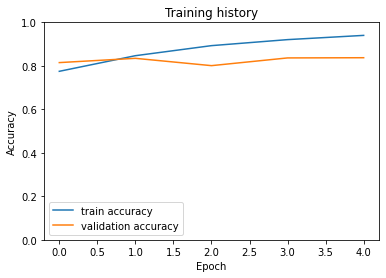

In [27]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [28]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

0.8373831775700935

In [30]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      tweets = d["tweets"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(tweets)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [31]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

In [32]:
class_name = ['Hope_speech','Non_hope_speech','not-Tamil']

In [33]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0))

                 precision    recall  f1-score   support

    Hope_speech       0.66      0.57      0.62       190
Non_hope_speech       0.88      0.91      0.89       784
      not-Tamil       0.77      0.80      0.79        96

       accuracy                           0.84      1070
      macro avg       0.77      0.76      0.76      1070
   weighted avg       0.83      0.84      0.83      1070



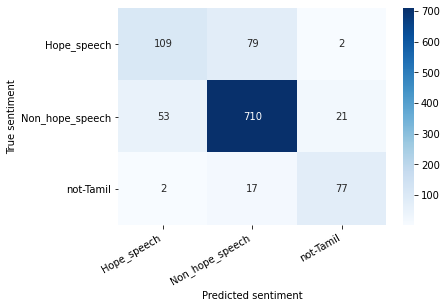

In [34]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)